In [1]:
import sys
sys.version
sys.version_info

sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)

In [4]:
from keras.utils import to_categorical
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split

In [5]:
TRAIN_LAB_PATH = "./data/train_labels.csv"
PREPROCESSED_TRAINING = "./data/processedData.npy"

In [68]:
CATEGORIES = ['apple', 'empty', 'moustache', 'mouth', 'mug', 'nail', 'nose', 'octagon', 'paintbrush', 'panda', 'parrot', 'peanut', 'pear', 'pencil', 'penguin', 'pillow', 'pineapple', 'pool', 'rabbit', 'rhinoceros', 'rifle', 'rollerskates', 'sailboat', 'scorpion', 'screwdriver', 'shovel', 'sink', 'skateboard', 'skull', 'spoon', 'squiggle']

def getIndexOf(category):
    return CATEGORIES.index(category)

def getCategoryOf(index):
    return CATEGORIES[index]

def load(infile):
    unformatted_images = np.load(infile, encoding='bytes')
    formatted = []
    for i,img in enumerate(unformatted_images):
        formatted.append([i, img[0]])
    return formatted

def formatXData(X):
    X = np.asarray(X)
    # Convert to matrix form
    X = X.reshape(-1, 40, 40, 1)
    # Convert to float
    X = X.astype('float32')
    # Scale pixel values between 0 and 1
    X = X / 255
    return X.astype('float32')

def addRotations(X,y):
    newX = []
    newY = []
    for i,XMatrix in enumerate(X):
        newX.append(XMatrix)
        newY.append(y[i])
        newX.append(np.rot90(XMatrix, 1))
        newY.append(y[i])
        newX.append(np.rot90(XMatrix, 2))
        newY.append(y[i])
        newX.append(np.rot90(XMatrix, 3))
        newY.append(y[i])
    return np.asarray(newX),np.asarray(newY)

def formatData(images, labels):
    categories = list(set(labels['Category']))
    X = []
    y = []
    for i, img in enumerate(images):
        label = labels.at[i,'Category']
        categoryNum = getIndexOf(label)
        X.append(img[1])
        y.append(categoryNum)
    y = to_categorical(y)
    X = formatXData(X)
    return X.astype('float32'), y

def split(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 
    return X_train, y_train, X_test, y_test, X_val, y_val


In [7]:
training_imgs = load(PREPROCESSED_TRAINING)

In [8]:
labels = pd.read_csv(TRAIN_LAB_PATH)

In [69]:
X,y = formatData(training_imgs, labels)

In [62]:
X,y = addRotations(X,y)

In [70]:
X_train, y_train, X_test, y_test, X_val, y_val = split(X,y)

In [106]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

In [71]:
batch_size = 64
epochs = 40
num_classes = len(CATEGORIES)
input_shape = (40, 40, 1)

In [127]:
 def createModel():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     kernel_initializer='he_normal',
                     input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
#     model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Dropout(0.4))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
    model.summary()
    return model

In [128]:
model = createModel()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 38, 38, 32)        320       
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 17, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_87 (Dropout)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 6, 6, 128)         73856     
_________________________________________________________________
dropout_88 (Dropout)         (None, 6, 6, 128)         0         
__________

In [129]:
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val, y_val))
score = model.evaluate(X_test, y_test, verbose=0)

Train on 6000 samples, validate on 2000 samples
Epoch 1/40
6000/6000 [==============================] - 20s 3ms/step - loss: 2.8155 - acc: 0.2002 - val_loss: 2.2696 - val_acc: 0.3420
Epoch 2/40
6000/6000 [==============================] - 18s 3ms/step - loss: 2.0899 - acc: 0.3903 - val_loss: 1.8728 - val_acc: 0.4855
Epoch 3/40
6000/6000 [==============================] - 18s 3ms/step - loss: 1.7471 - acc: 0.4928 - val_loss: 1.7035 - val_acc: 0.5345
Epoch 4/40
6000/6000 [==============================] - 18s 3ms/step - loss: 1.5012 - acc: 0.5600 - val_loss: 1.5415 - val_acc: 0.5795
Epoch 5/40
6000/6000 [==============================] - 17s 3ms/step - loss: 1.3126 - acc: 0.6152 - val_loss: 1.4184 - val_acc: 0.6130
Epoch 6/40
6000/6000 [==============================] - 17s 3ms/step - loss: 1.1423 - acc: 0.6652 - val_loss: 1.4054 - val_acc: 0.6015
Epoch 7/40
6000/6000 [==============================] - 18s 3ms/step - loss: 0.9952 - acc: 0.7037 - val_loss: 1.4155 - val_acc: 0.6235
Epoch 8

In [130]:
score

[2.3103012809753416, 0.6395]

In [131]:
import csv
import matplotlib.pyplot as plt
import time

In [132]:
preprocessed_kaggle = load('./data/processed_kaggle.npy')
X_kaggle = formatXData(list(map(lambda x: x[1], preprocessed_kaggle)))
kaggle_predictions = model.predict(X_kaggle)

def savePredictions(outfile, predictions):
    with open(outfile,'w') as csvfile:
        fieldnames = ['Id', 'Category']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for i, prediction in enumerate(predictions):
            index = np.argmax(prediction)
            writer.writerow({'Id': i, 'Category': getCategoryOf(index)})

In [133]:
ts = time.time()
timestamp = int(ts)
savePredictions('./data/prediction_'+ str(timestamp) + '_' + str(score[1]) + '.csv', kaggle_predictions)

sailboat


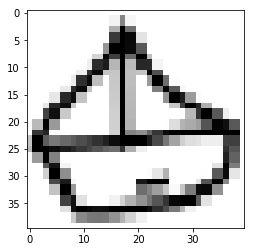

moustache


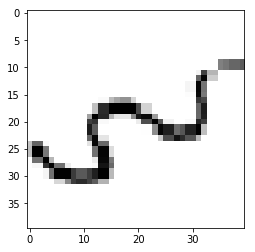

octagon


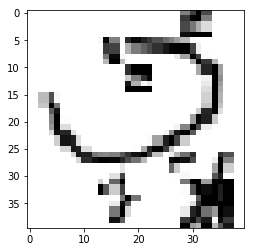

squiggle


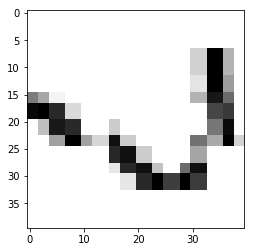

nail


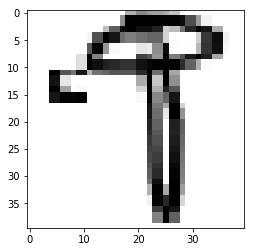

apple


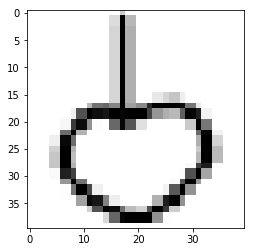

apple


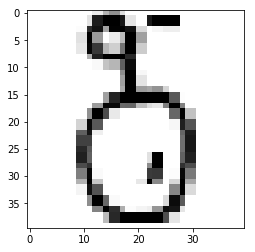

pillow


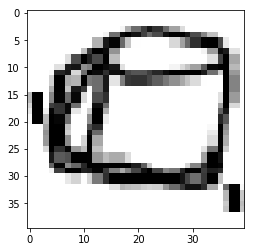

rifle


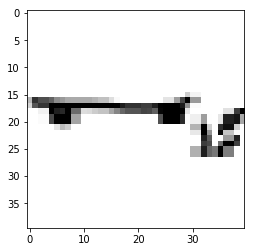

moustache


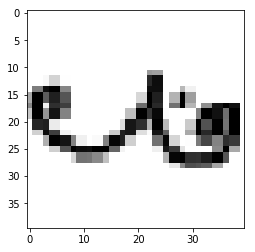

peanut


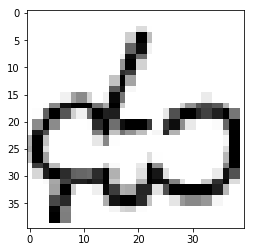

mouth


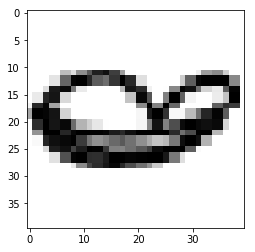

empty


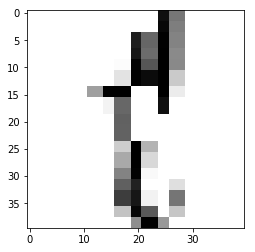

parrot


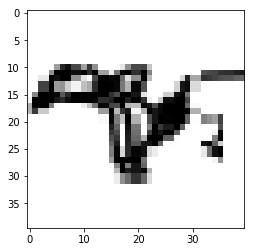

spoon


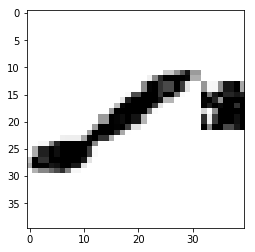

shovel


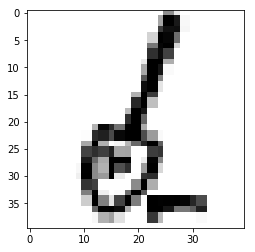

peanut


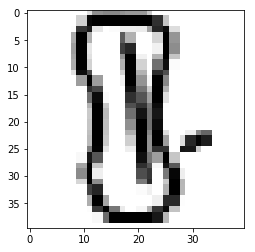

rifle


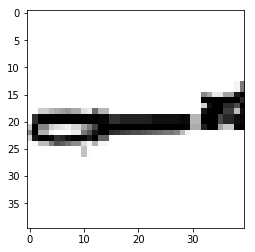

panda


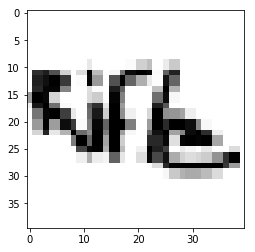

empty


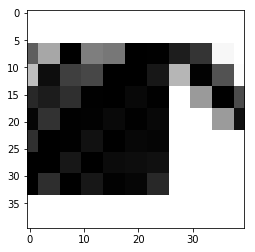

pineapple


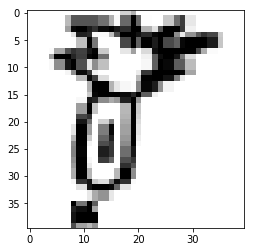

sailboat


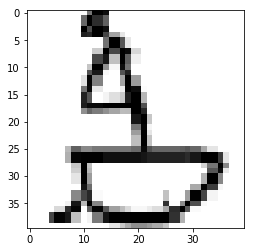

pillow


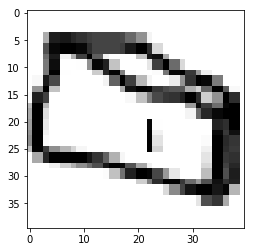

moustache


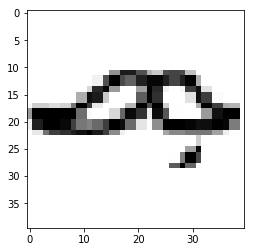

apple


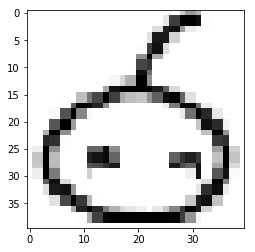

octagon


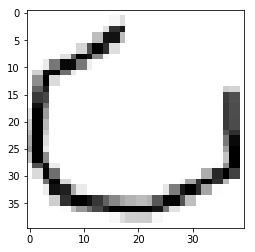

sailboat


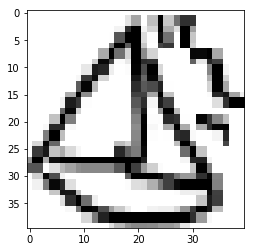

pool


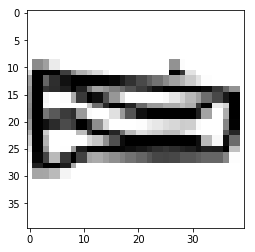

sink


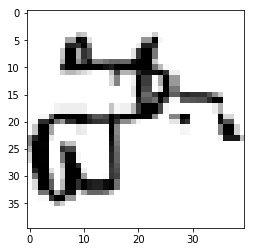

pool


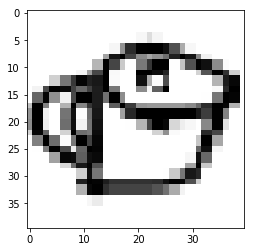

rabbit


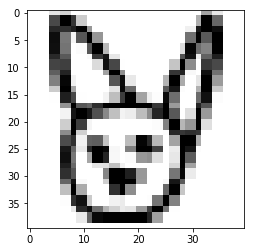

pillow


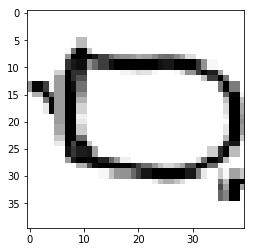

empty


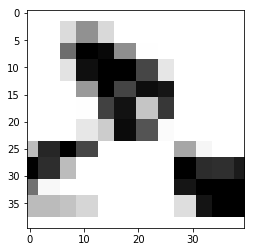

paintbrush


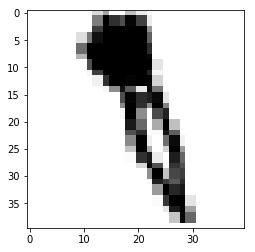

pool


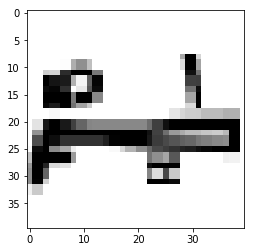

sailboat


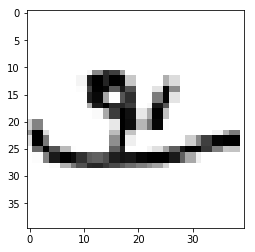

rollerskates


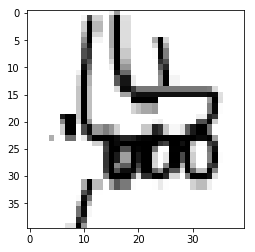

scorpion


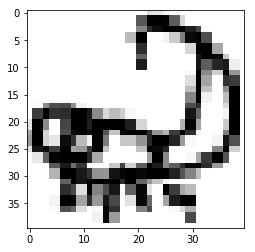

pillow


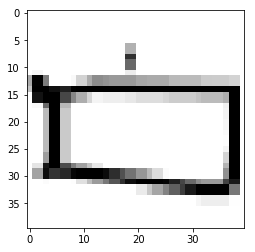

sink


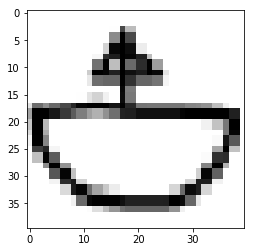

nail


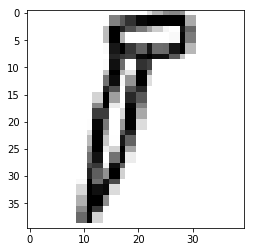

mouth


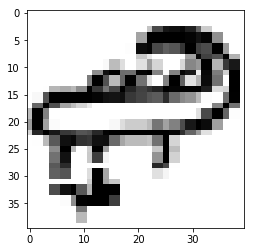

spoon


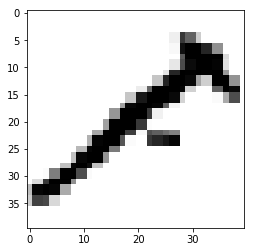

pool


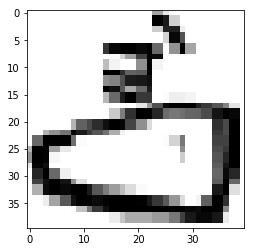

rhinoceros


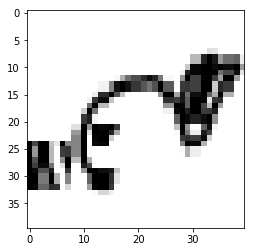

pool


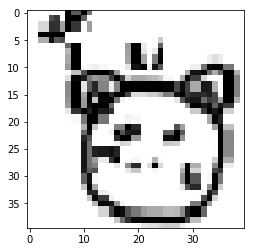

pear


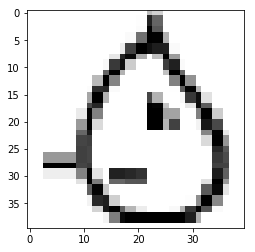

rollerskates


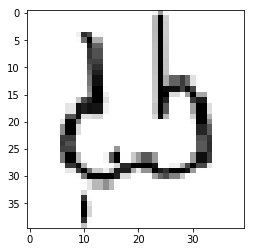

mouth


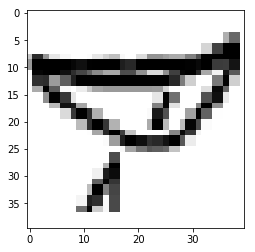

pencil


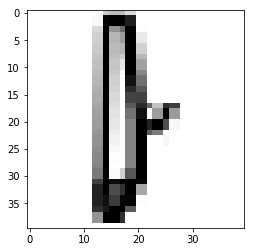

rifle


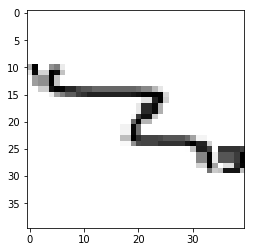

rifle


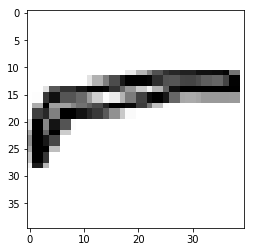

shovel


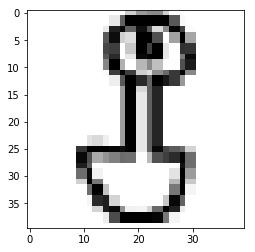

moustache


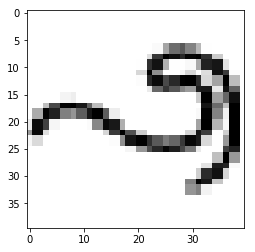

pool


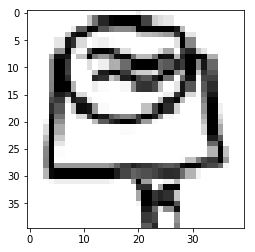

nail


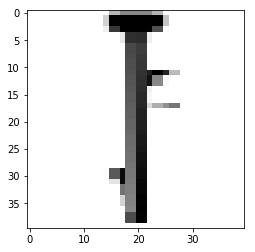

apple


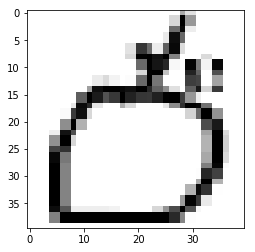

spoon


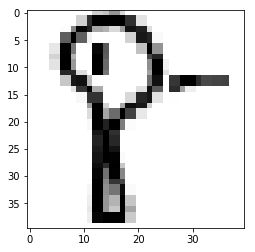

rabbit


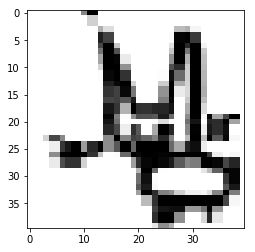

octagon


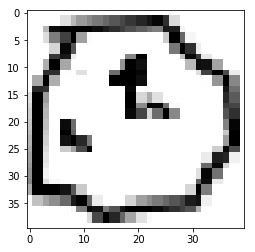

parrot


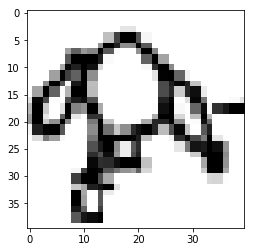

nose


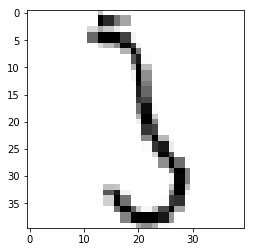

pencil


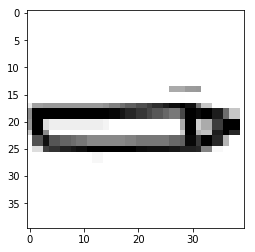

pool


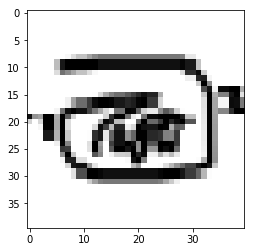

mouth


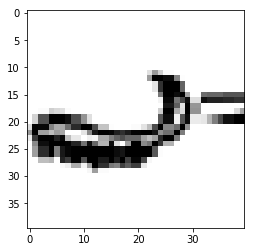

parrot


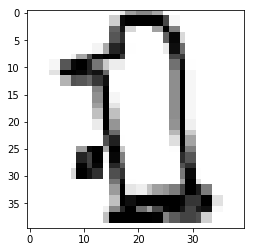

squiggle


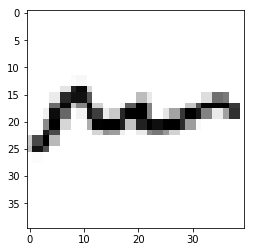

pineapple


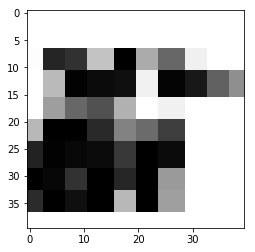

scorpion


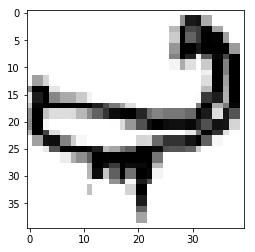

octagon


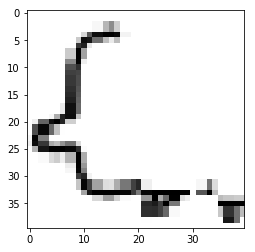

pear


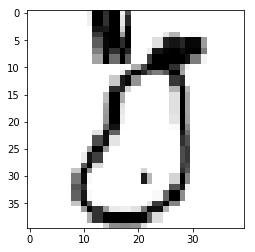

rifle


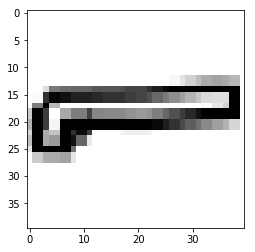

penguin


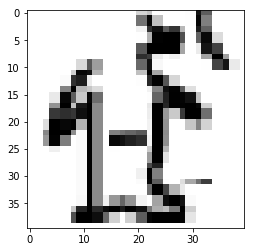

apple


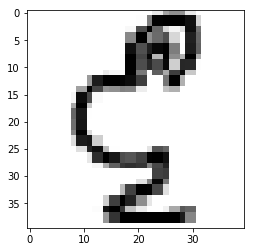

penguin


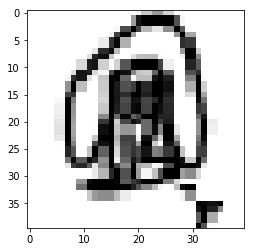

paintbrush


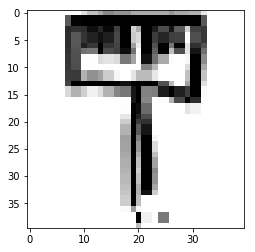

empty


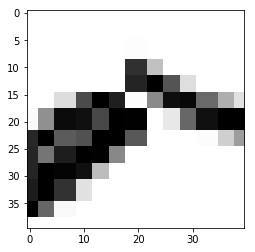

moustache


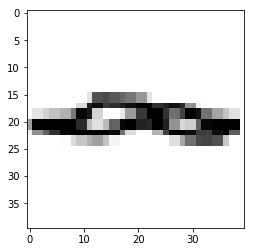

penguin


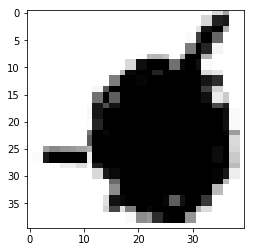

rhinoceros


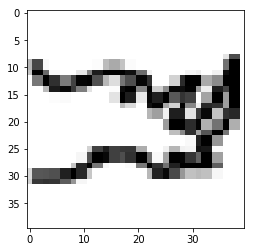

penguin


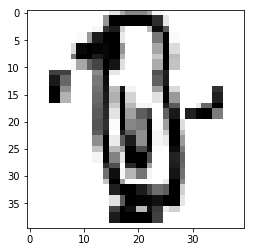

sailboat


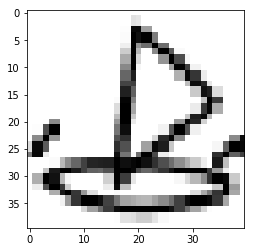

rollerskates


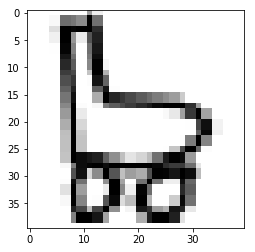

pineapple


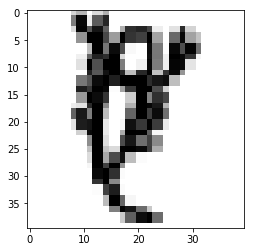

pillow


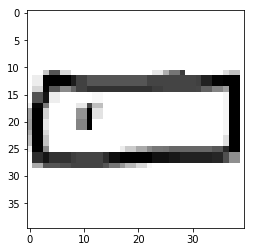

nail


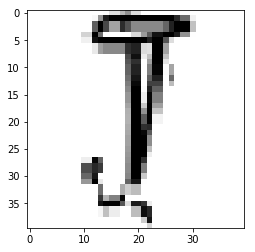

penguin


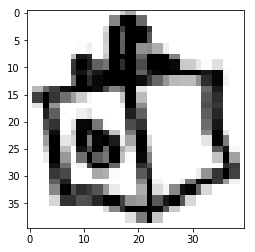

pool


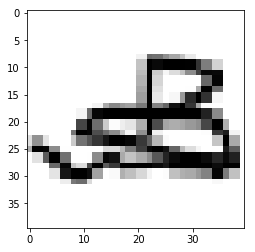

octagon


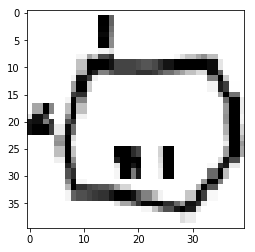

empty


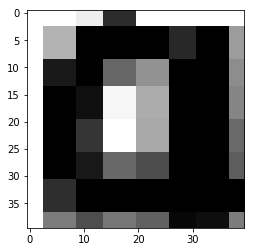

pineapple


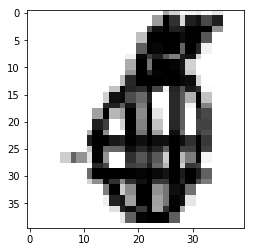

rabbit


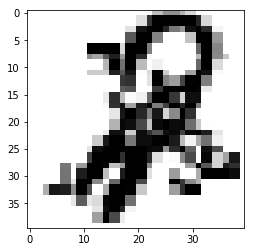

sailboat


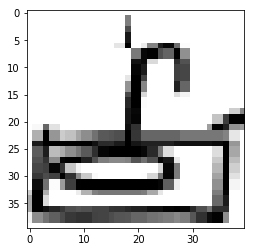

pool


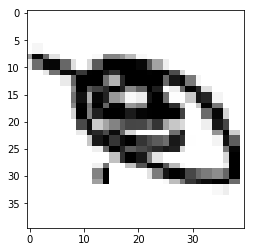

pineapple


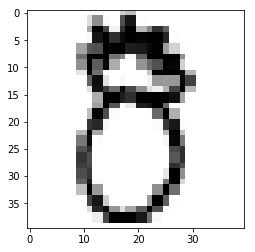

skull


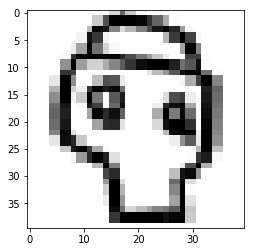

pillow


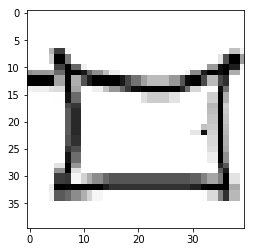

shovel


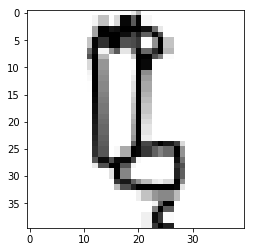

pool


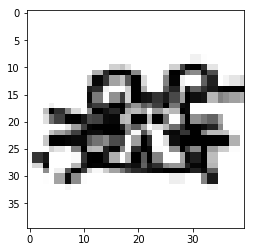

mouth


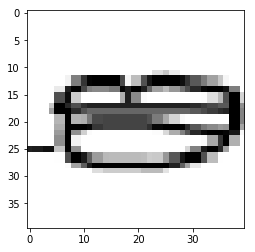

In [134]:
for i, img in list(enumerate(preprocessed_kaggle))[100:200]:
    img = img[1].reshape((40,40)).astype(np.uint8)
    index = np.argmax(kaggle_predictions[i])
    print(getCategoryOf(index))
    plt.imshow(img, cmap='gray_r')
    plt.show()